In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import re

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

from sklearn.model_selection import train_test_split

import xgboost as xgb

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential

from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error

import warnings
warnings.filterwarnings('ignore')


In [6]:
df=pd.read_csv("SolarPrediction.csv")


In [7]:
df['Data']=df['Data'].apply(lambda x: x.split()[0])

In [8]:
df['Month']=pd.to_datetime(df['Data']).dt.month
df['Day']=pd.to_datetime(df['Data']).dt.day
df['Year']=pd.to_datetime(df['Data']).dt.year
df['Hour']=pd.to_datetime(df['Time']).dt.hour
df['Minute']=pd.to_datetime(df['Time']).dt.minute
df['Second']=pd.to_datetime(df['Time']).dt.second

In [9]:
df['SunriseHour']=df['TimeSunRise'].apply(lambda x: re.search(r'^\d+',x).group(0)).astype(int)
df['SunriseMinute']=df['TimeSunRise'].apply(lambda x: re.search(r':(\d+)',x).group(1)).astype(int)
df['SunsetHour']=df['TimeSunSet'].apply(lambda x: re.search(r':(\d+)',x).group(1)).astype(int)
df['SunsetMinute']=df['TimeSunSet'].apply(lambda x: re.search(r':(\d+)',x).group(1)).astype(int)

In [10]:
df.drop(['UNIXTime','Data','Time','TimeSunRise','TimeSunSet'],axis=1,inplace=True)

In [11]:
df.isnull().sum().sum()

0

In [12]:
input_features=df.drop(['Radiation'],axis=1)
output_features=df['Radiation']

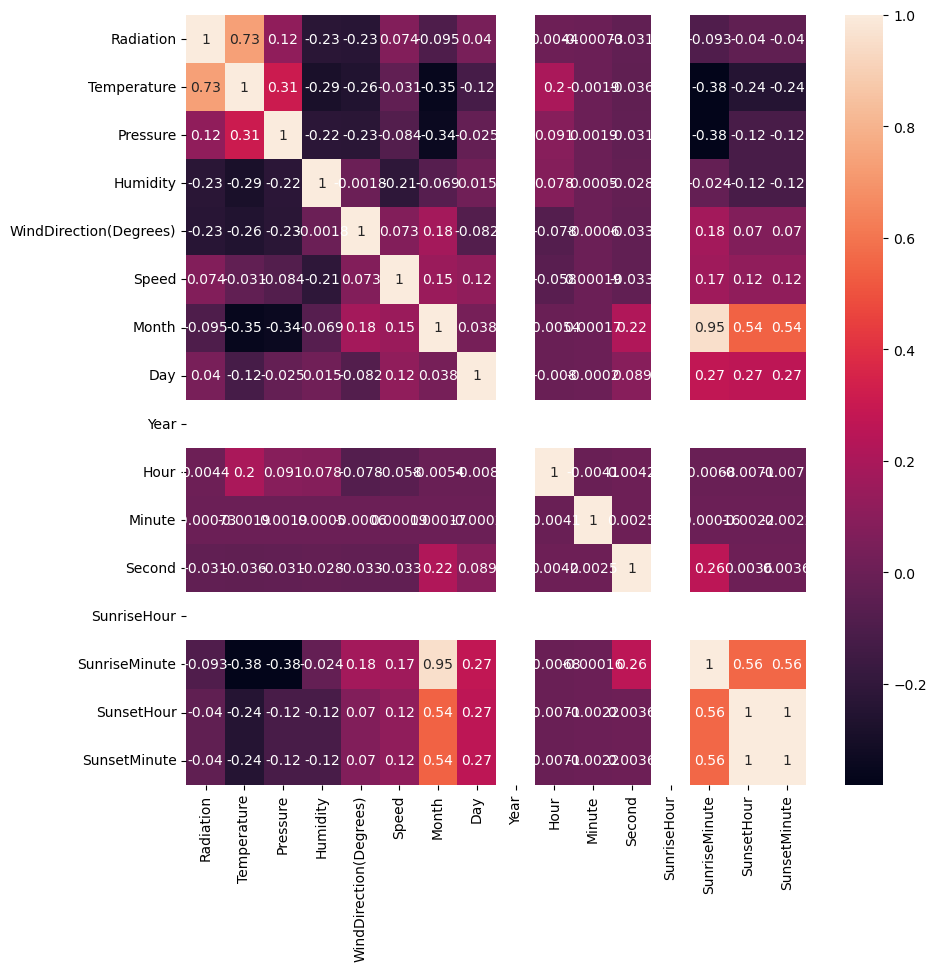

In [13]:
cor=df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(cor,annot=True)
plt.show()

In [14]:
del df

In [15]:
output_features=output_features.apply(lambda x: int(x*100))

In [16]:
scalar=MinMaxScaler()
scaled_input_features=scalar.fit_transform(input_features)
input_features_columns=input_features.columns

In [17]:
feature_selector= SelectKBest(chi2,k='all')
selected_features=feature_selector.fit(scaled_input_features,output_features)

In [18]:
imp=pd.DataFrame(selected_features.scores_,index=input_features_columns,columns=['Importance'])
imp.sort_values(by='Importance',ascending=False, inplace=True)
imp

,Importance
Month,4684.579610
SunriseMinute,4015.062771
WindDirection(Degrees),3271.827277
Day,2841.926850
Minute,2702.449333
Second,2288.673032
SunsetHour,1863.712087
SunsetMinute,1863.712087
Temperature,1651.685632
Humidity,1588.087433


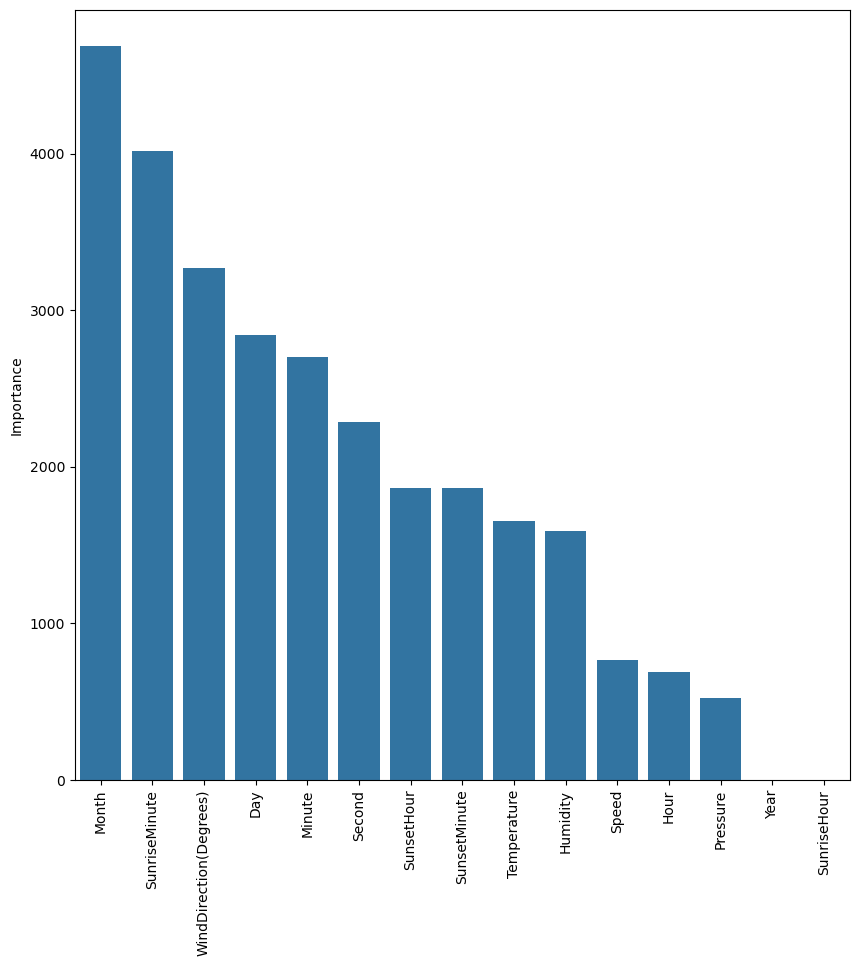

In [19]:
plt.figure(figsize=(10,10))
sns.barplot(imp.Importance)
plt.xticks(rotation=90)
plt.show()

In [84]:
model=ExtraTreesClassifier(n_estimators=20,verbose=2, n_jobs=-1)
model.fit(scaled_input_features,output_features)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 20building tree 2 of 20
building tree 3 of 20

building tree 4 of 20
building tree 5 of 20


MemoryError: could not allocate 937361408 bytes

In [42]:
imp=pd.DataFrame(model.feature_importances_,index=input_features_columns,columns=['Importance'])
imp.sort_values(by='Importance',ascending=False,inplace=True)
imp

,Importance
Temperature,0.0
Pressure,0.0
Humidity,0.0
WindDirection(Degrees),0.0
Speed,0.0
Month,0.0
Day,0.0
Year,0.0
Hour,0.0
Minute,0.0


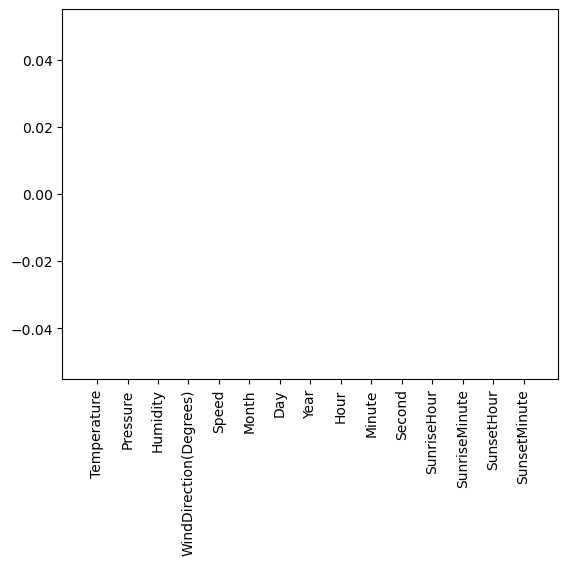

In [44]:
plt.bar(imp.index,imp['Importance'])
plt.xticks(rotation=90)
plt.show()

In [46]:
#feature Engineering

In [48]:
input_features.drop(['Year','SunriseHour'],axis=1)
pd.DataFrame(input_features)


,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Year,Hour,Minute,Second,SunriseHour,SunriseMinute,SunsetHour,SunsetMinute
0,48,30.46,59,177.39,5.62,9,29,2016,23,55,26,6,13,13,13
1,48,30.46,58,176.78,3.37,9,29,2016,23,50,23,6,13,13,13
2,48,30.46,57,158.75,3.37,9,29,2016,23,45,26,6,13,13,13
3,48,30.46,60,137.71,3.37,9,29,2016,23,40,21,6,13,13,13
4,48,30.46,62,104.95,5.62,9,29,2016,23,35,24,6,13,13,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32681,44,30.43,102,145.42,6.75,12,1,2016,0,20,4,6,41,42,42
32682,44,30.42,102,117.78,6.75,12,1,2016,0,15,1,6,41,42,42
32683,44,30.42,102,145.19,9.00,12,1,2016,0,10,1,6,41,42,42
32684,44,30.42,101,164.19,7.87,12,1,2016,0,5,2,6,41,42,42


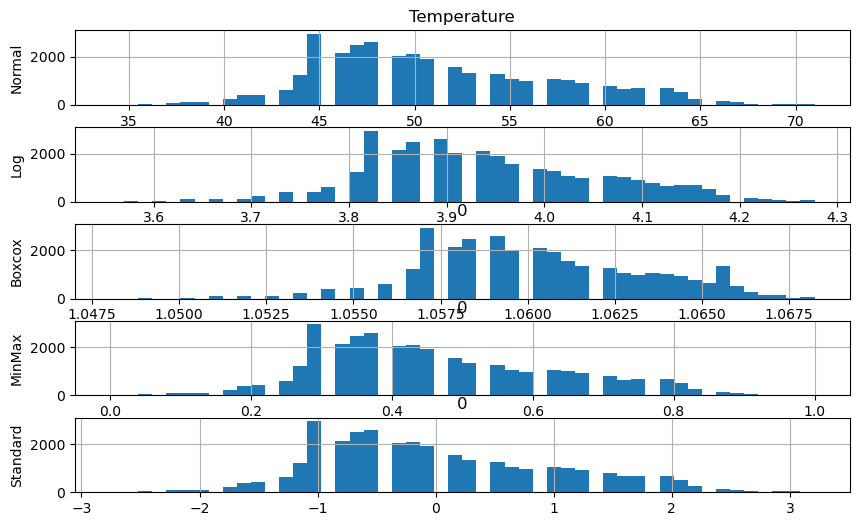

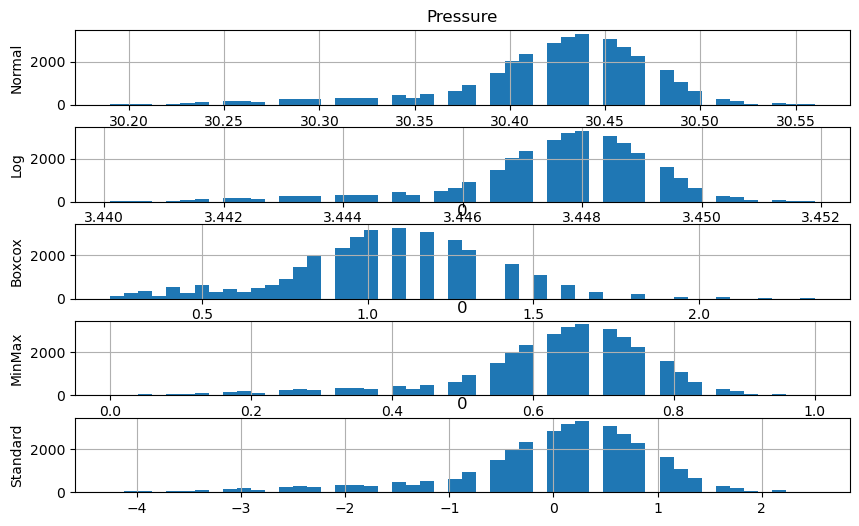

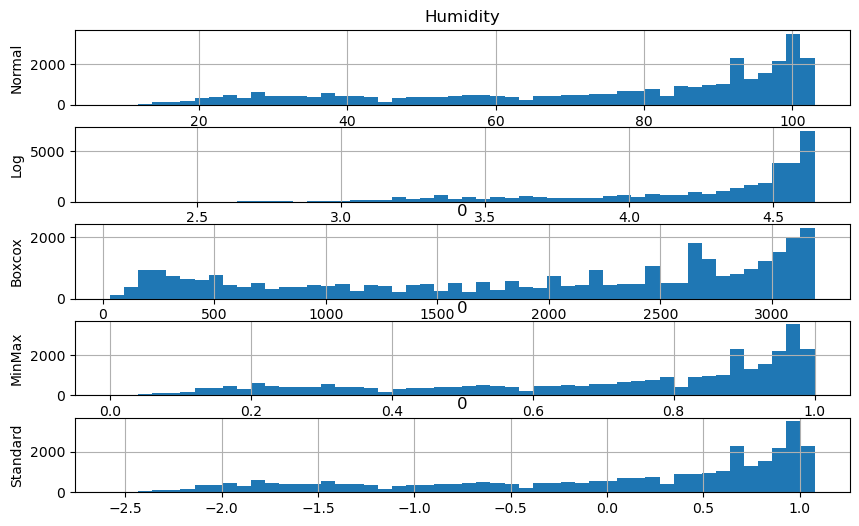

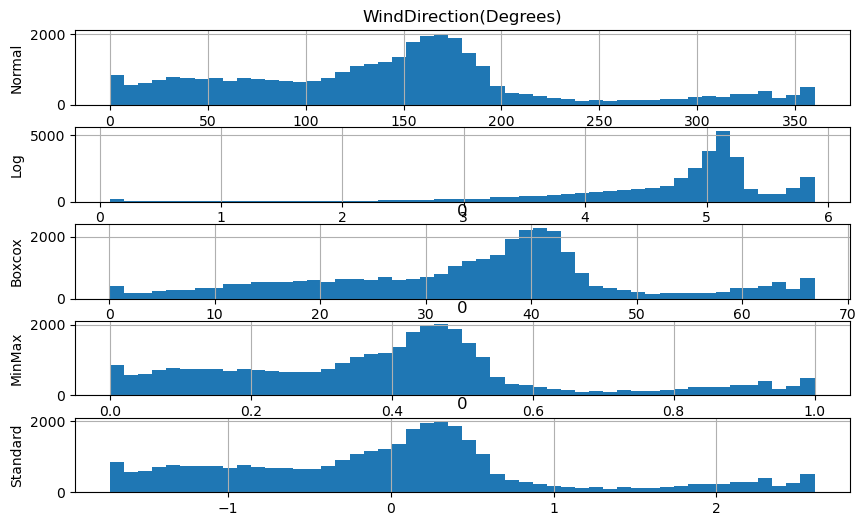

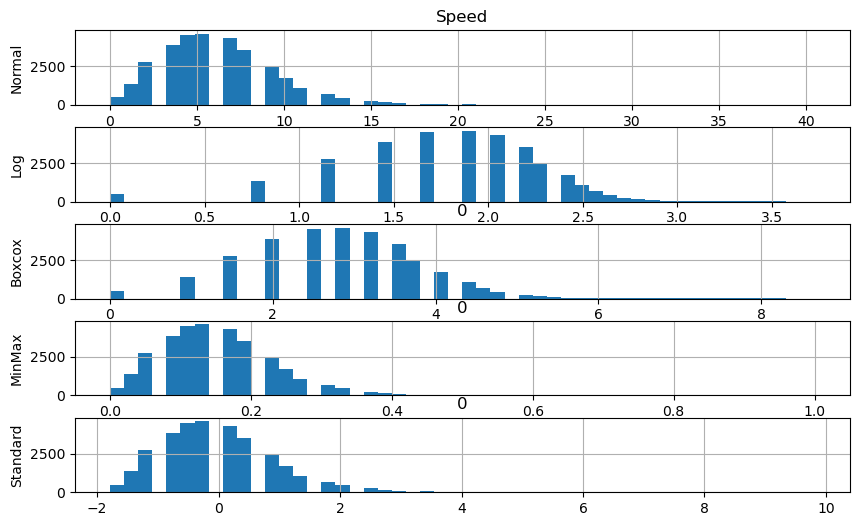

In [50]:
transform_features=['Temperature','Pressure','Humidity','WindDirection(Degrees)','Speed']
for i in transform_features:
    fig, (ax1,ax2,ax3,ax4,ax5)= plt.subplots(5,1, figsize=(10,6))
    input_features[i].hist(ax=ax1, bins=50)
    ((input_features[i]+1).transform(np.log)).hist(ax=ax2, bins=50)
    pd.DataFrame(stats.boxcox(input_features[i]+1)[0]).hist(ax=ax3, bins=50)
    pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame(input_features[i]))).hist(ax=ax4, bins=50)    
    pd.DataFrame(StandardScaler().fit_transform(pd.DataFrame(input_features[i]))).hist(ax=ax5, bins=50)    
    ax1.set_ylabel('Normal')
    ax2.set_ylabel('Log')
    ax3.set_ylabel('Boxcox')
    ax4.set_ylabel('MinMax')
    ax5.set_ylabel('Standard')
    ax1.set_title(i)

In [52]:
transform={'Temperture':(input_features["Temperature"]+1).transform(np.log),
           'Speed': (input_features['Speed']+1).transform(np.log),
           'WindDirection(Degrees)': MinMaxScaler().fit_transform(pd.DataFrame(input_features['WindDirection(Degrees)'])),
           'Pressure': stats.boxcox(input_features['Pressure']+1)[0],
           'Humidity': stats.boxcox(input_features['Humidity']+1)[0]}
           

In [54]:
for i in transform:
    input_features[i]=transform[i]

In [56]:
xTrain, xTest, yTrain, yTest=train_test_split(input_features,output_features, test_size=0.3)

In [58]:
pd.DataFrame(xTrain)

,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Year,Hour,Minute,Second,SunriseHour,SunriseMinute,SunsetHour,SunsetMinute,Temperture
7855,51,1.327548e+297,2855.771784,0.075224,2.047693,10,30,2016,11,20,18,6,23,49,49,3.951244
24051,61,9.660719e+296,188.784136,0.060662,2.182675,11,2,2016,15,20,18,6,24,48,48,4.127134
10442,49,1.169123e+297,3077.931532,0.232896,1.704748,10,21,2016,11,5,21,6,19,55,55,3.912023
21492,63,1.414595e+297,809.703539,0.037403,2.302585,11,11,2016,12,50,4,6,29,44,44,4.158883
23677,48,1.327548e+297,484.150465,0.482188,1.178655,11,3,2016,22,35,18,6,25,47,47,3.891820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20181,46,1.169123e+297,291.664161,0.473545,2.182675,11,16,2016,2,10,2,6,32,43,43,3.850148
21313,44,1.245832e+297,2092.237027,0.509420,1.890095,11,12,2016,3,45,5,6,30,44,44,3.806662
6130,57,8.506123e+296,2641.383910,0.932085,1.704748,9,5,2016,16,50,7,6,8,35,35,4.060443
19714,58,8.506123e+296,145.195449,0.189740,1.474763,11,17,2016,17,5,22,6,32,43,43,4.077537


In [60]:
scaler=StandardScaler()
xTrain=scaler.fit_transform(xTrain)
xTest=scaler.transform(xTest)

#XGBoost

In [63]:
from xgboost import XGBRegressor

model=XGBRegressor(learning_rate=0.1,max_depth=8)
model.fit(xTrain,yTrain)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [65]:
y_pred=model.predict(xTest)

In [67]:
rmse=np.sqrt(mean_squared_error(yTest,y_pred))
r2=r2_score(yTest,y_pred)

print(f"rmse : {rmse:.2f}")
print(f"r2 : {r2:.2f}")

rmse : 8226.98
r2 : 0.93


#Multilayer Perceptron Model

In [70]:
yTrain.apply(lambda x: x/100)

7855     361.41
24051    578.92
10442    542.29
21492    870.88
23677      1.21
          ...  
20181      1.21
21313      1.22
6130     128.43
19714     75.45
5946     576.26
Name: Radiation, Length: 22880, dtype: float64

In [72]:

yTest.apply(lambda x: x/100)

18786      1.20
31259    415.72
6281       3.37
1945       1.23
25364      1.18
          ...  
30240      1.32
28020      1.23
23141      1.22
10662    302.20
21055      1.21
Name: Radiation, Length: 9806, dtype: float64

In [74]:
model=Sequential([
    Dense(123,activation='relu',input_dim=16),
    Dropout(0.33),
    Dense(64,activation='relu'),
    Dropout(0.33),
    Dense(32,activation='relu'),
    Dropout(0.33),
    Dense(1)
])
    


In [76]:
model.compile(optimizer='adam',loss='mse',metrics=['mse'])

In [78]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 123)                 │           2,091 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 123)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           7,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,140 (47.42 KB)

 Trainable params: 12,140 (47.42 KB)

 Non-trainable params: 0 (0.00 B)

In [80]:
history=model.fit(xTrain,yTrain,validation_split=0.1,epochs=20,batch_size=32)

Epoch 1/20
644/644 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 2/20
644/644 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 3/20
644/644 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 4/20
644/644 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 5/20
644/644 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 6/20
644/644 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 7/20
644/644 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 8/20
644/644 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 9/20
644/644 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 10/20
644/644 ━━━━━━━━━━━━━━━━━━━━ 3s 5m

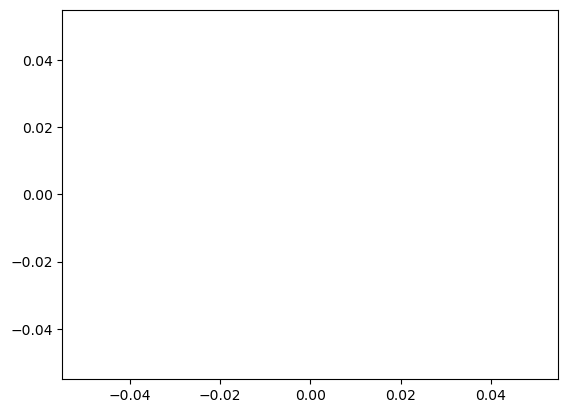

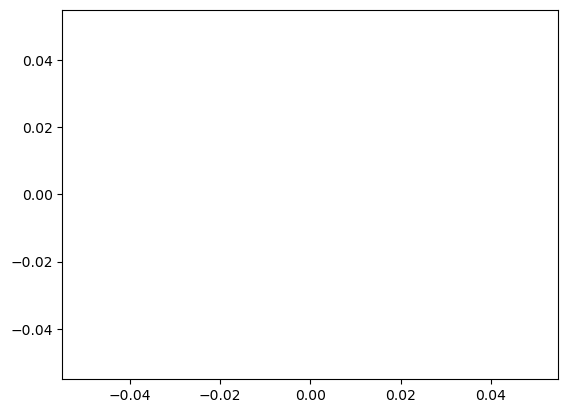

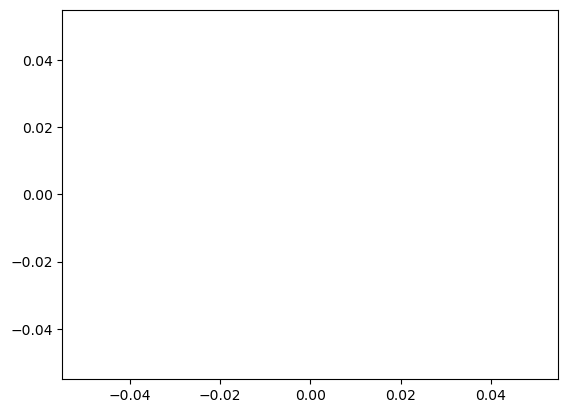

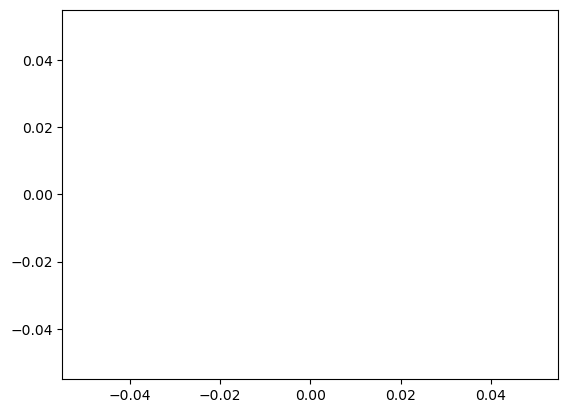

In [82]:
fit=history.history
for i in fit:
    plt.plot(fit[i])
    plt.show()